# Preprocesamiento de los datos

**Catálogo de valores:**

*Número_de_inclusiones:* 1 <15 ; 2 = 15–30 ; 3 = 31 – 45; 4 >45

*Agujeros:* 1 – absent; 2 – light; 3 – noticeable; 4 – great

*Lineas_de_corrosion:* 1 – absent; 2 – slight; 3 – noticeable

*Señal_quimica:* 1 – light; 2 – moderate; 3 – heavy

*Diametro_mm:* 1 < 5; 2 = 5–9.9 ; 3 = 10–19.9; 4 >20

*Arreglo_de_inclusiones:* 1 – no visible; 2 – fragmented; 3 – articulated; 4 – isolated

*Forma_de_fracturas_en_terminaciones:* 1 – blunt; 2 – pinched; 3 – straight; 4 – irregular; 5 – all types 

## Inspección de los datos

### Importar librerías

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os

### Cargar datos

In [29]:
# Load the data
df = pd.read_excel('data/raw/coprolitos_raw.xlsx')

### Inspeccionar primero elementos de nuestros datos

In [30]:
df.head()

,Ejemplar,# inclusiones,agujeros,líneas de corrosión,señal química,diamétro (mm),arreglo de inclusiones,forma de fracturas en terminaciones
0,1 bump headed lace,4,2.0,1.0,1.0,1,2,5.0
1,2 bump headed lace,4,2.0,2.0,1.0,1,2,3.0
2,3 circular,1,2.0,1.0,1.0,1,4,5.0
3,4 circular,3,2.0,2.0,1.0,2,4,5.0
4,5 cilíndrico,1,NaN,NaN,NaN,3,1,NaN


Notamos que los valores de la columna Ejemplar contiene texto adicional, lo eliminamos para quedarnos solo con el nombre.

In [31]:
# Función Viowi

# Definir una función que realiza la transformación...
def limpiar_columna(texto):
    # Eliminar los números
    texto_sin_numeros = re.sub(r'\d+', '', texto)
    # Eliminar espacios a la izquierda y a la derecha
    texto_limpio = texto_sin_numeros.strip()
    return texto_limpio

# Aplicar la función a la columna del DataFrame
df['Ejemplar'] = df['Ejemplar'].apply(limpiar_columna)

# Imprimir los nuevos valores de la columna Ejemplar
df['Ejemplar'].unique()


array(['bump headed lace', 'circular', 'cilíndrico', 'ciclíndrico',
       'cono', 'elipsoidal', 'elongado', 'forma de pino', 'irregular',
       'forma de rosario', 'espiral', 'forma de encaje recto',
       'encaje delgado'], dtype=object)

Notamos que existe un typo en "ciclíndrico" 

In [32]:
df.loc[df['Ejemplar'] == 'ciclíndrico', 'Ejemplar'] = 'cilíndrico';

# Imprimos nuevamente los valores de la columna
df['Ejemplar'].unique()

array(['bump headed lace', 'circular', 'cilíndrico', 'cono', 'elipsoidal',
       'elongado', 'forma de pino', 'irregular', 'forma de rosario',
       'espiral', 'forma de encaje recto', 'encaje delgado'], dtype=object)

### Cambiar el nombre de las columnas

In [33]:
# Cambiar el nombre de las columnas
df = df.rename(columns={'# inclusiones': 'Numero_de_inclusiones', 'agujeros': 'Agujeros', 'líneas de corrosión': 'Lineas_de_corrosion', 'señal química': 'Señal_quimica', 'diamétro (mm)': 'Diametro_mm', 'arreglo de inclusiones' : 'Arreglo_de_inclusiones', 'forma de fracturas en terminaciones': 'Forma_de_fracturas_en_terminaciones'})

# Imprimir nuevas columnas
df.columns

Index(['Ejemplar', 'Numero_de_inclusiones', 'Agujeros', 'Lineas_de_corrosion',
       'Señal_quimica', 'Diametro_mm', 'Arreglo_de_inclusiones',
       'Forma_de_fracturas_en_terminaciones'],
      dtype='object')

### Valores pérdidos

In [34]:
df.isna().sum()

Ejemplar                               0
Numero_de_inclusiones                  0
Agujeros                               4
Lineas_de_corrosion                    4
Señal_quimica                          4
Diametro_mm                            0
Arreglo_de_inclusiones                 0
Forma_de_fracturas_en_terminaciones    4
dtype: int64

### Imputar valores pérdidos

Creamos un DataFrame solo con las filas que contienen valores pérdidos.

In [35]:
# Extraer las filas que contienen al menos un valor perdido
df_with_missing_values = df[df.isnull().any(axis=1)]

df_with_missing_values

,Ejemplar,Numero_de_inclusiones,Agujeros,Lineas_de_corrosion,Señal_quimica,Diametro_mm,Arreglo_de_inclusiones,Forma_de_fracturas_en_terminaciones
4,cilíndrico,1,NaN,NaN,NaN,3,1,NaN
6,cilíndrico,1,NaN,NaN,NaN,3,1,NaN
13,irregular,1,NaN,NaN,NaN,4,1,NaN
17,espiral,1,NaN,NaN,NaN,1,4,NaN


Para imputar vamos a utilizar la moda de los elementos que pertenecen al mismo Ejemplar. Dado que el Ejemplar "espiral" solo se encuentra una vez en nuestro Dataset, recurriremos al elemento más parecido. Tras consultarlo con la experta, sugiere que nos basemos en el ejemplar "cono". 

In [36]:
# Imputar valores perdidos con la moda de las filas que tienen el mismo valor en 'Ejemplar'
for row in df_with_missing_values.index:
    for col in df_with_missing_values.columns:
        if pd.isna(df_with_missing_values.loc[row, col]):
            ejemplar_value = df_with_missing_values.loc[row, 'Ejemplar']
            moda_value = df[df['Ejemplar'] == ejemplar_value][col].mode()
            if not moda_value.empty:
                df.loc[row, col] = moda_value[0]
            if df_with_missing_values.loc[row, 'Ejemplar'] == 'espiral':
                moda_value = df[df['Ejemplar'] == 'cono'][col].mode()
                df.loc[row, col] = moda_value[0]
            print(f'Valor nulo imputado en la fila {row} ({df.loc[row,'Ejemplar']}), columna {col} con la moda {moda_value[0]}')

Valor nulo imputado en la fila 4 (cilíndrico), columna Agujeros con la moda 2.0
Valor nulo imputado en la fila 4 (cilíndrico), columna Lineas_de_corrosion con la moda 1.0
Valor nulo imputado en la fila 4 (cilíndrico), columna Señal_quimica con la moda 1.0
Valor nulo imputado en la fila 4 (cilíndrico), columna Forma_de_fracturas_en_terminaciones con la moda 5.0
Valor nulo imputado en la fila 6 (cilíndrico), columna Agujeros con la moda 2.0
Valor nulo imputado en la fila 6 (cilíndrico), columna Lineas_de_corrosion con la moda 1.0
Valor nulo imputado en la fila 6 (cilíndrico), columna Señal_quimica con la moda 1.0
Valor nulo imputado en la fila 6 (cilíndrico), columna Forma_de_fracturas_en_terminaciones con la moda 5.0
Valor nulo imputado en la fila 13 (irregular), columna Agujeros con la moda 2.0
Valor nulo imputado en la fila 13 (irregular), columna Lineas_de_corrosion con la moda 1.0
Valor nulo imputado en la fila 13 (irregular), columna Señal_quimica con la moda 1.0
Valor nulo imputad

### Tipo de datos

In [24]:
df.dtypes

Ejemplar                                object
Numero_de_inclusiones                    int64
Agujeros                               float64
Lineas_de_corrosion                    float64
Señal_quimica                          float64
Diametro_mm                              int64
Arreglo_de_inclusiones                   int64
Forma_de_fracturas_en_terminaciones    float64
dtype: object

Dado que todos los valores son enteros representando categorías, convertimos los valores flotantes a enteros.

In [25]:
# Convertir las columnas especificadas a valores enteros, ignorando los valores perdidos
columns_to_convert = df.drop("Ejemplar", axis=1).columns
df[columns_to_convert] = df[columns_to_convert].apply(lambda x: pd.to_numeric(x, downcast='integer', errors='coerce'))

df.dtypes

Ejemplar                               object
Numero_de_inclusiones                    int8
Agujeros                                 int8
Lineas_de_corrosion                      int8
Señal_quimica                            int8
Diametro_mm                              int8
Arreglo_de_inclusiones                   int8
Forma_de_fracturas_en_terminaciones      int8
dtype: object

### Almacenar datos procesados

In [27]:
# Ruta de la carpeta donde se guardaran los datos procesadoos
folder_path = 'data/processed/'

# Verificar si la carpeta no existe y crearla si es necesario
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Ahora puedes guardar el DataFrame en formato Parquet
df.to_excel(folder_path + 'coprolitos_processed.xlsx', index=False)

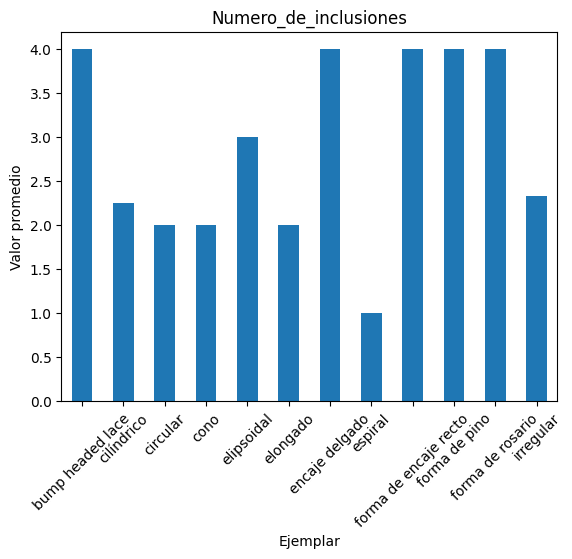

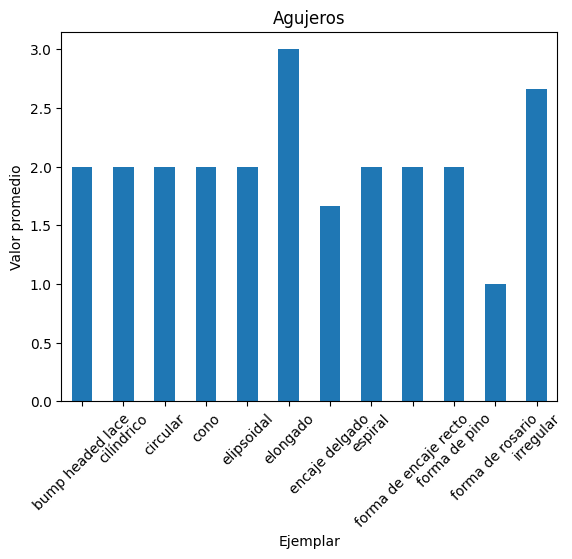

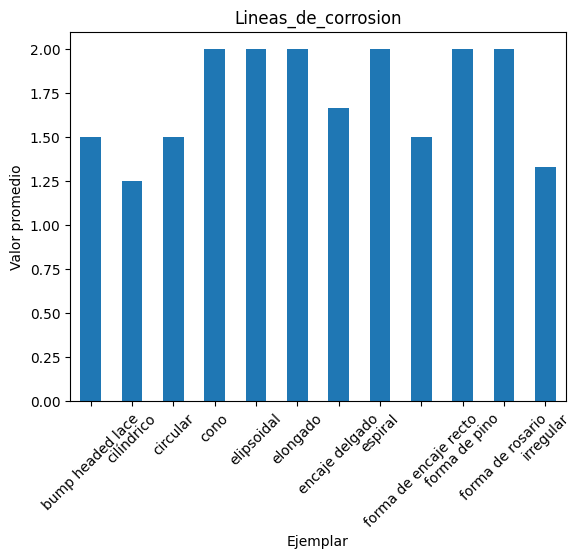

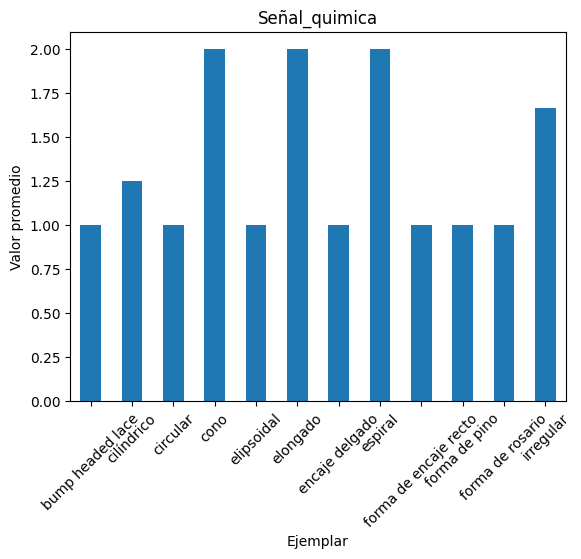

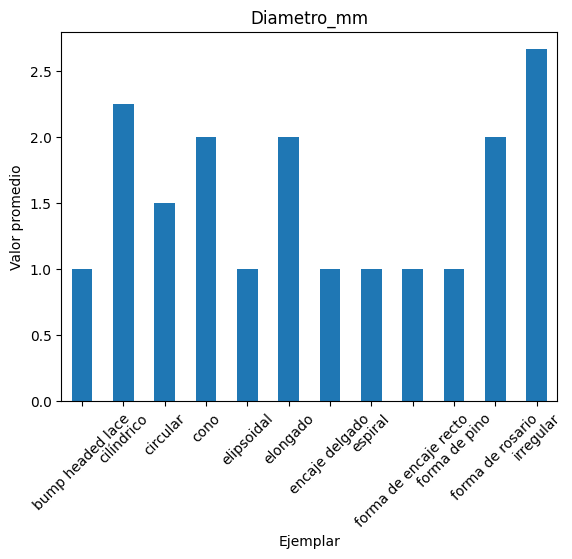

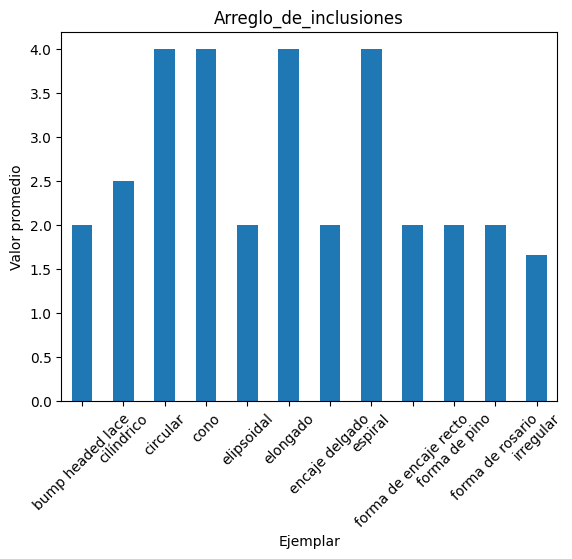

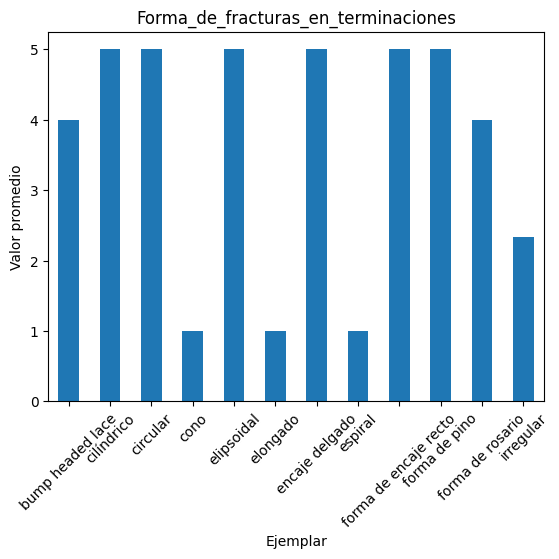

In [13]:
# Agrupar por 'Ejemplar' y calcular la media de cada grupo
grouped_df = df.groupby('Ejemplar').mean()

# Graficar las distintas columnas, una gráfica por columna
for column in grouped_df.columns:
    plt.figure()
    grouped_df[column].plot(kind='bar')
    plt.title(column)
    plt.ylabel('Valor promedio')
    plt.xlabel('Ejemplar')
    plt.xticks(rotation=45)
    plt.show()

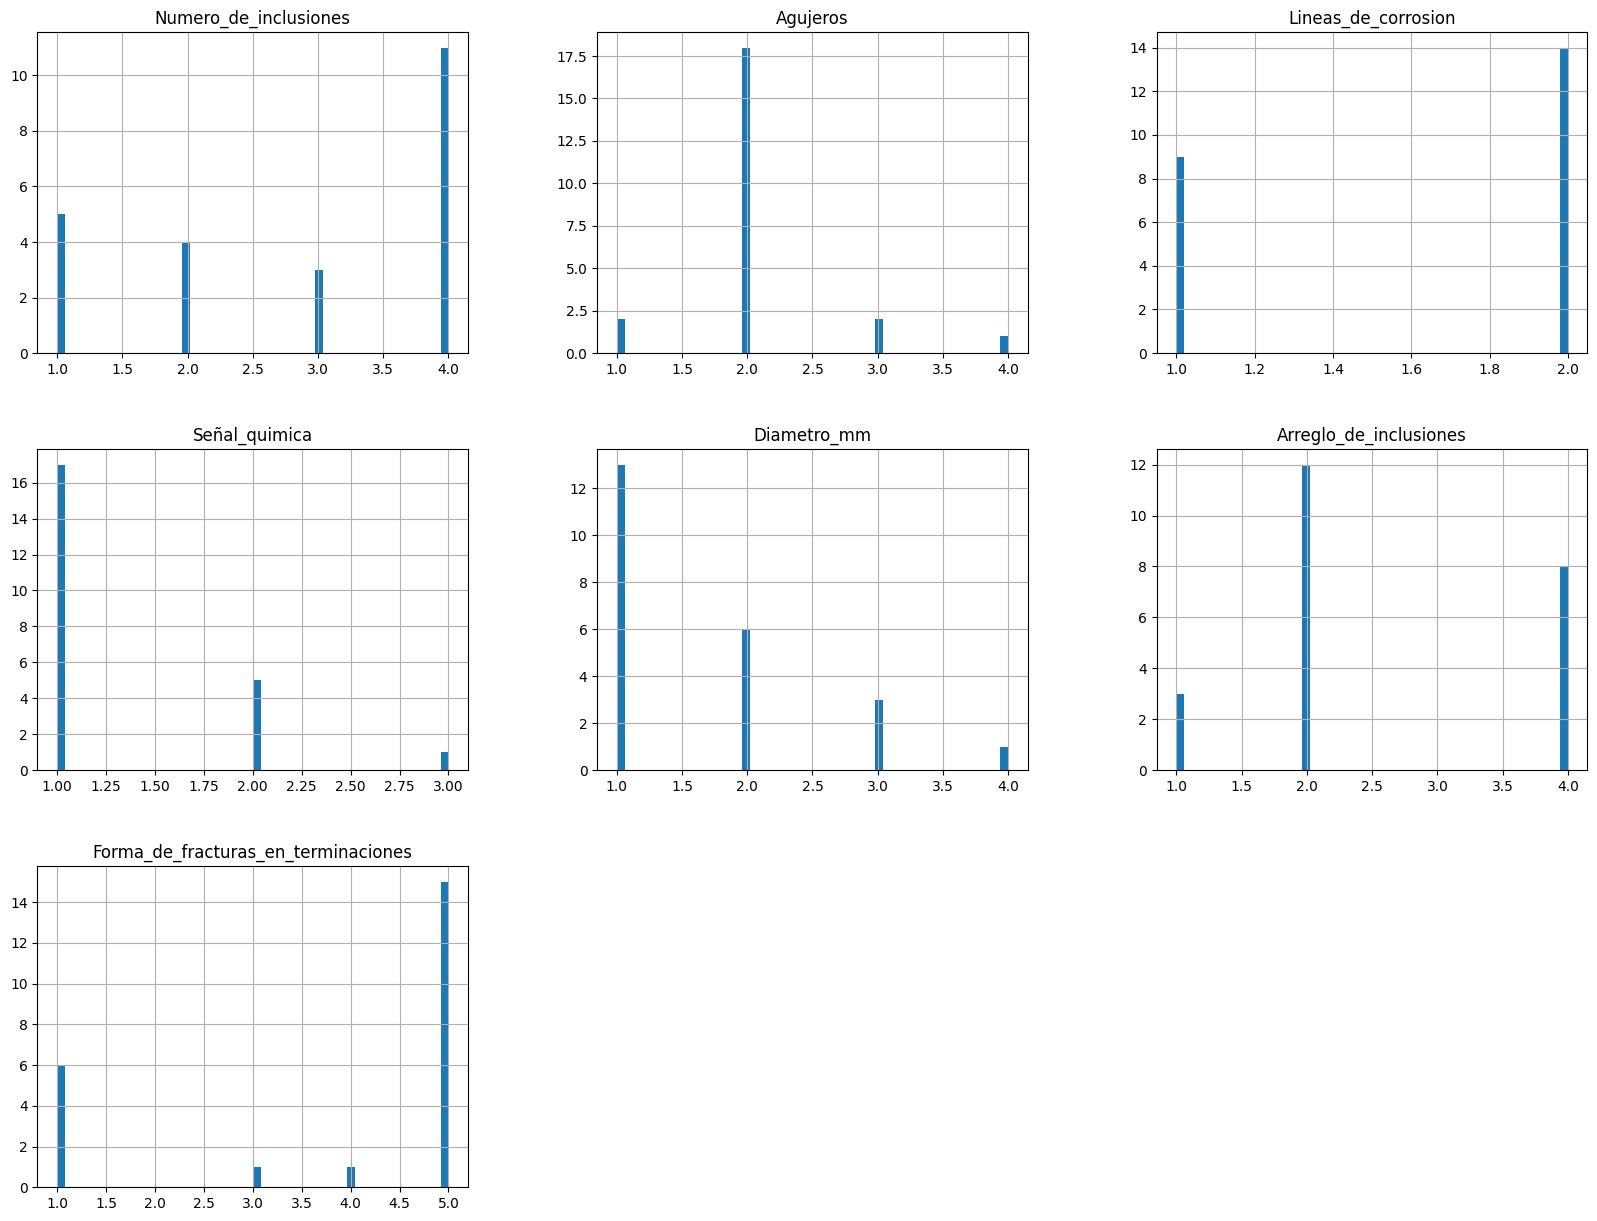

In [13]:
# Hacemos un histograma para cada columna
df.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: >

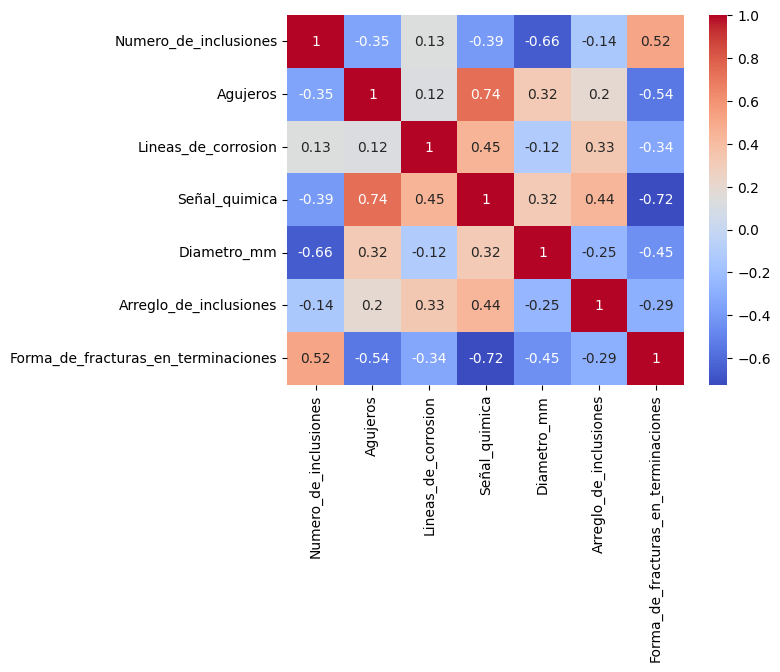

In [14]:
# Vemos si hay correlación entre las variables con un heatmap
sns.heatmap(df.iloc[:,1:].corr(), annot=True, cmap='coolwarm')

In [ ]:
df.to_csv('data/processed.csv')

In [24]:
from sklearn.metrics import pairwise_distances

In [25]:
pd.DataFrame(pairwise_distances(df.drop('Ejemplar',axis=1), metric='braycurtis'))

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.000000,0.096774,0.161290,0.142857,0.200000,0.166667,0.200000,0.058824,0.354839,0.062500,...,0.407407,0.393939,0.000000,0.125000,0.379310,0.030303,0.000000,0.000000,0.030303,0.062500
1,0.096774,0.000000,0.266667,0.176471,0.310345,0.200000,0.310345,0.151515,0.266667,0.096774,...,0.384615,0.312500,0.096774,0.096774,0.285714,0.062500,0.096774,0.096774,0.062500,0.096774
2,0.161290,0.266667,0.000000,0.117647,0.172414,0.142857,0.172414,0.090909,0.266667,0.161290,...,0.384615,0.437500,0.161290,0.290323,0.214286,0.187500,0.161290,0.161290,0.187500,0.225806
3,0.142857,0.176471,0.117647,0.000000,0.212121,0.025641,0.212121,0.081081,0.176471,0.085714,...,0.400000,0.333333,0.142857,0.142857,0.250000,0.111111,0.142857,0.142857,0.111111,0.142857
4,0.200000,0.310345,0.172414,0.212121,0.000000,0.235294,0.000000,0.250000,0.379310,0.200000,...,0.200000,0.354839,0.200000,0.266667,0.407407,0.225806,0.200000,0.200000,0.225806,0.266667
5,0.166667,0.200000,0.142857,0.025641,0.235294,0.000000,0.235294,0.105263,0.142857,0.111111,...,0.419355,0.297297,0.166667,0.166667,0.212121,0.135135,0.166667,0.166667,0.135135,0.166667
6,0.200000,0.310345,0.172414,0.212121,0.000000,0.235294,0.000000,0.250000,0.379310,0.200000,...,0.200000,0.354839,0.200000,0.266667,0.407407,0.225806,0.200000,0.200000,0.225806,0.266667
7,0.058824,0.151515,0.090909,0.081081,0.250000,0.105263,0.250000,0.000000,0.272727,0.117647,...,0.448276,0.428571,0.058824,0.176471,0.290323,0.085714,0.058824,0.058824,0.085714,0.117647
8,0.354839,0.266667,0.266667,0.176471,0.379310,0.142857,0.379310,0.272727,0.000000,0.290323,...,0.307692,0.187500,0.354839,0.290323,0.071429,0.312500,0.354839,0.354839,0.312500,0.354839
9,0.062500,0.096774,0.161290,0.085714,0.200000,0.111111,0.200000,0.117647,0.290323,0.000000,...,0.407407,0.333333,0.062500,0.125000,0.310345,0.030303,0.062500,0.062500,0.030303,0.062500
